## Лабораторная работа №1

Выполнил: Болдинова


1. блок

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Union, Optional
import warnings

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


warnings.filterwarnings('ignore')

2. блок. константы
   

In [129]:
EPSILON = 1e-8
TARGET_COL = "RiskScore"
ID_COL = "ID"
SEED = 42
BEST_ALPHA = 10.0  
FEATURE_PERCENTILE = 90  

3 блок. ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ

In [140]:
def safe_log_transform(x: np.ndarray) -> np.ndarray:
    return np.sign(x) * np.log1p(np.abs(x))


def robust_clip(values: np.ndarray, lower: float, upper: float) -> np.ndarray:
    return np.clip(values, lower, upper)


4. блок

In [130]:
class ModelMetrics:
    @staticmethod
    def compute_mse(actual: np.ndarray, predicted: np.ndarray) -> float:
        return np.mean((actual - predicted) ** 2)

    @staticmethod
    def compute_mae(actual: np.ndarray, predicted: np.ndarray) -> float:
        return np.mean(np.abs(actual - predicted))

    @staticmethod
    def compute_mape(actual: np.ndarray, predicted: np.ndarray) -> float:
        denominator = np.abs(actual) + EPSILON
        return np.mean(np.abs((actual - predicted) / denominator)) * 100

    @staticmethod
    def compute_r2(actual: np.ndarray, predicted: np.ndarray) -> float:
        ss_residual = np.sum((actual - predicted) ** 2)
        ss_total = np.sum((actual - np.mean(actual)) ** 2)
        return 1 - ss_residual / (ss_total + EPSILON)


5 блок. КАСТОМНАЯ РЕГРЕССИЯ

In [131]:
class CustomRegressor:

    def __init__(self,
                 method: str = 'analytical',
                 regularization: Optional[str] = None,
                 reg_strength: float = 0.01,
                 learning_rate: float = 0.001,
                 max_iterations: int = 5000,
                 batch_size: int = 32,
                 power: int = 2): 

        self.method = method
        self.regularization = regularization
        self.reg_strength = reg_strength
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.batch_size = batch_size
        self.power = power

        self.weights = None
        self.bias = None
        self.loss_history = []

    def fit(self, X: np.ndarray, y: np.ndarray):
        n_samples, n_features = X.shape

        self.weights = np.zeros(n_features)
        self.bias = 0.0

        if self.method == 'analytical':
            X_b = np.c_[np.ones((n_samples, 1)), X]

            if self.regularization == 'l2':
                I = np.eye(n_features + 1)
                I[0, 0] = 0  
                theta = np.linalg.solve(
                    X_b.T @ X_b + self.reg_strength * I,
                    X_b.T @ y
                )
            else:
                theta = np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y

            self.bias = theta[0]
            self.weights = theta[1:]

        elif self.method in ['gd', 'sgd']:
            for i in range(self.max_iterations):
                if self.method == 'gd':
                    self._step(X, y, n_samples)
                else:  
                    indices = np.random.permutation(n_samples)
                    X_shuffled = X[indices]
                    y_shuffled = y[indices]
                    for j in range(0, n_samples, self.batch_size):
                        X_batch = X_shuffled[j:j + self.batch_size]
                        y_batch = y_shuffled[j:j + self.batch_size]
                        self._step(X_batch, y_batch, len(X_batch))

    def _step(self, X_batch, y_batch, n):
        y_pred = X_batch @ self.weights + self.bias
        error = y_pred - y_batch

        dw = (2 / n) * (X_batch.T @ error)
        db = (2 / n) * np.sum(error)

        if self.regularization == 'l2':
            dw += 2 * self.reg_strength * self.weights
        elif self.regularization == 'l1':
            dw += self.reg_strength * np.sign(self.weights)
        elif self.regularization == 'lp':
            dw += self.reg_strength * self.power * np.sign(self.weights) * (
                        np.abs(self.weights) ** (self.power - 1))

        self.weights -= self.learning_rate * dw
        self.bias -= self.learning_rate * db

    def predict(self, X: np.ndarray) -> np.ndarray:
        return X @ self.weights + self.bias

6 блок. ИНЖЕНЕРИЯ ПРИЗНАКОВ

In [132]:
class FeatureEngineer:
    @staticmethod
    def add_bins(df: pd.DataFrame, column: str, bins: list) -> None:
        if column not in df.columns:
            return
        labels = [f"{i}" for i in range(len(bins) - 1)]
        df[f"{column}_Bin"] = pd.cut(
            df[column], bins=bins, labels=labels, include_lowest=True
        ).astype(str)

    def process(self, df: pd.DataFrame, is_train: bool = True) -> pd.DataFrame:
        df = df.copy()

        if "ApplicationDate" in df.columns:
            parsed = pd.to_datetime(df["ApplicationDate"], errors="coerce")
            df["App_Year"] = parsed.dt.year
            df["App_Month"] = parsed.dt.month
            df["App_Quarter"] = parsed.dt.quarter
            df["App_Week"] = parsed.dt.isocalendar().week.astype(float)
            df.drop(columns=["ApplicationDate"], inplace=True)

        edu_map = {'High School': 1, 'Associate': 2, 'Bachelor': 3, 'Master': 4, 'Doctorate': 5}
        if 'EducationLevel' in df.columns:
            df['EducationLevel'] = df['EducationLevel'].map(edu_map).fillna(0)

        df["InterestRateSpread"] = df["InterestRate"] - df["BaseInterestRate"]
        df["LoanToIncome"] = df["LoanAmount"] / (df["AnnualIncome"] + EPSILON)

        total_debt = df["MonthlyLoanPayment"] + df["MonthlyDebtPayments"]
        df["DebtServiceRatio"] = total_debt / (df["MonthlyIncome"] + EPSILON)
        df["DisposableIncome"] = df["MonthlyIncome"] - total_debt

        df["AssetCoverage"] = df["TotalAssets"] / (df["TotalLiabilities"] + EPSILON)
        df["LiabilityGap"] = df["TotalLiabilities"] - df["TotalAssets"]
        df["LogLiabilityGap"] = safe_log_transform(df["LiabilityGap"].values)  
        df.drop(columns=["LiabilityGap"], inplace=True)

        df["NetWorthToLiabilities"] = df["NetWorth"] / (df["TotalLiabilities"] + EPSILON)
        df["NetWorthToIncome"] = df["NetWorth"] / (df["AnnualIncome"] + EPSILON)

        df["UtilizationPerLine"] = df["CreditCardUtilizationRate"] / (
                    df["NumberOfOpenCreditLines"] + 1)
        df["InquiryPerLine"] = df["NumberOfCreditInquiries"] / (df["NumberOfOpenCreditLines"] + 1)

        df["IncomePerDependent"] = df["AnnualIncome"] / (df["NumberOfDependents"] + 1)
        df["ExperienceToAge"] = df["Experience"] / (df["Age"] + EPSILON)
        df["IncomeDiscrepancy"] = df["AnnualIncome"] - (df["MonthlyIncome"] * 12.0)
        df["AgeAfterExperience"] = df["Age"] - df["Experience"]

        self.add_bins(df, "CreditScore", [300, 580, 620, 660, 700, 740, 780, 820, 900])
        self.add_bins(df, "Age", [18, 30, 45, 60, 100])
        self.add_bins(df, "AnnualIncome", [0, 40000, 80000, 150000, 1e9])

        return df


7. блок. ПАЙПЛАЙН 

In [133]:
class RegressionPipeline:
    def __init__(self, reg_type='custom', method='analytical', alpha=1.0):
        self.reg_type = reg_type 
        self.method = method  
        self.alpha = alpha 

        self.num_imputer = None
        self.cat_modes = None
        self.scaler = None
        self.poly = None
        self.ohe = None
        self.selector = None
        self.model = None

        self.numeric_cols = None
        self.cat_cols = None

    def fit(self, X: pd.DataFrame, y: pd.Series):
        self.numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        self.cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

        self.num_imputer = X[self.numeric_cols].median()
        self.cat_modes = X[self.cat_cols].mode().iloc[0]

        X_filled = X.copy()
        X_filled[self.numeric_cols] = X_filled[self.numeric_cols].fillna(self.num_imputer)
        X_filled[self.cat_cols] = X_filled[self.cat_cols].fillna(self.cat_modes)

        X_log = X_filled.copy()
        X_log[self.numeric_cols] = safe_log_transform(X_log[self.numeric_cols].values)

        self.poly = PolynomialFeatures(degree=2, include_bias=False)
        X_poly = self.poly.fit_transform(X_log[self.numeric_cols])
        self.scaler = StandardScaler()
        X_poly_scaled = self.scaler.fit_transform(X_poly)

        self.ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        X_cat_encoded = self.ohe.fit_transform(X_log[self.cat_cols])

        X_final = np.hstack([X_poly_scaled, X_cat_encoded])

        self.selector = SelectPercentile(score_func=f_regression, percentile=FEATURE_PERCENTILE)
        X_selected = self.selector.fit_transform(X_final, y)

        if self.reg_type == 'sklearn':
            self.model = Ridge(alpha=self.alpha)
            self.model.fit(X_selected, y)
        else:
            self.model = CustomRegressor(
                method=self.method,
                regularization='l2',
                reg_strength=self.alpha
            )
            self.model.fit(X_selected, y.values)

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        X_filled = X.copy()
        X_filled[self.numeric_cols] = X_filled[self.numeric_cols].fillna(self.num_imputer)
        X_filled[self.cat_cols] = X_filled[self.cat_cols].fillna(self.cat_modes)

        X_log = X_filled.copy()
        X_log[self.numeric_cols] = safe_log_transform(X_log[self.numeric_cols].values)

        X_poly = self.poly.transform(X_log[self.numeric_cols])
        X_poly_scaled = self.scaler.transform(X_poly)

        X_cat_encoded = self.ohe.transform(X_log[self.cat_cols])

        X_final = np.hstack([X_poly_scaled, X_cat_encoded])
        X_selected = self.selector.transform(X_final)

        if self.reg_type == 'sklearn':
            return self.model.predict(X_selected)
        else:
            return self.model.predict(X_selected)

8. блок. КРОСС-ВАЛИДАЦИЯ

In [137]:
class CrossValidator:
    def __init__(self, k=5):
        self.k = k

    def k_fold_score(self, X, y, model_params):
        kf = KFold(n_splits=self.k, shuffle=True, random_state=SEED)
        mse_scores = []

        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            pipeline = RegressionPipeline(**model_params)
            pipeline.fit(X_train, y_train)
            preds = pipeline.predict(X_val)
            preds = robust_clip(preds, 0, 100)

            mse_scores.append(ModelMetrics.compute_mse(y_val.values, preds))

        return np.mean(mse_scores), np.std(mse_scores)


class DataAnalyzer:
    def show_correlations(self, df, target):
        numeric_df = df.select_dtypes(include=[np.number])
        corr = numeric_df.corr()[target].sort_values(ascending=False)
        print(f"Top 5 Positive Correlations with {target}:")
        print(corr.head(6)[1:]) 
        print(f"Top 5 Negative Correlations with {target}:")
        print(corr.tail(5))

        plt.figure(figsize=(10, 8))
        # Top 10 features heatmap
        top_cols = corr.abs().sort_values(ascending=False).head(11).index
        sns.heatmap(numeric_df[top_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
        plt.title("Correlation Matrix of Top Features")
        plt.show()

9 блок

Loading Data...
Preprocessing Target...
Engineering Features...

--- EDA Summary ---
Top 5 Positive Correlations with RiskScore:
BaseInterestRate          0.758712
InterestRate              0.742634
DebtServiceRatio          0.532384
TotalDebtToIncomeRatio    0.530729
LoanToIncome              0.506330
Name: RiskScore, dtype: float64
Top 5 Negative Correlations with RiskScore:
IncomePerDependent   -0.577064
AnnualIncome         -0.758514
MonthlyIncome        -0.770267
DisposableIncome     -0.778284
CreditScore          -0.785425
Name: RiskScore, dtype: float64


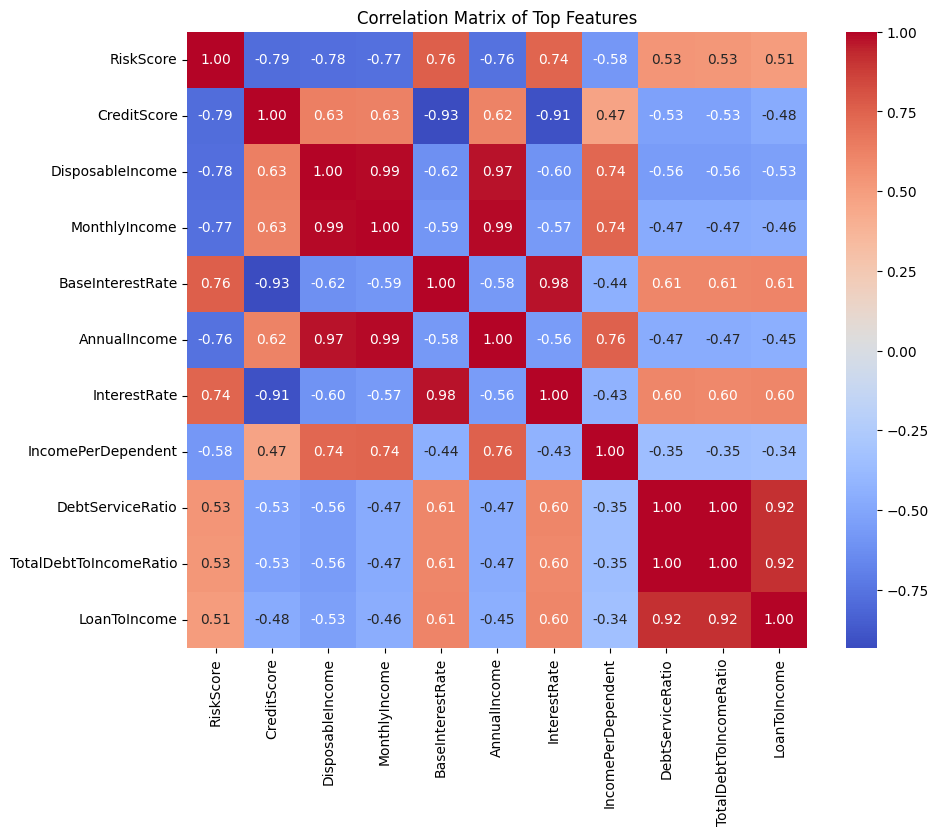


--- Model Evaluation (Cross-Validation) ---
Model: custom (analytical)       | MSE: 28.0573 ± 1.3200
Model: sklearn (analytical)      | MSE: 28.0573 ± 1.3200

--- Metrics Comparison on Validation Split ---
Metric     | Custom     | Sklearn (OLS)
------------------------------------
MSE        | 28.7573    | 32.9150   
MAE        | 4.0087     | 4.1033    
R2         | 0.9038     | 0.8899    

Training Final Model (Best MSE: 28.0573)...
Submission saved to D:/Laba ML/LabaLaba1/submission.csv


In [141]:

        
    # 1. Пути к файлам (ЗАМЕНИТЕ НА СВОИ!)
    TRAIN_PATH = "D:/Laba ML/LabaLaba1/train.csv"
    TEST_PATH = "D:/Laba ML/LabaLaba1/test.csv"
    OUTPUT_PATH = "D:/Laba ML/LabaLaba1/submission.csv"

    print("Loading Data...")
    train_df = pd.read_csv(TRAIN_PATH)
    test_df = pd.read_csv(TEST_PATH)

    # 2. Базовый препроцессинг (EDA: Целевая переменная)
    print("Preprocessing Target...")
    train_df = train_df.dropna(subset=[TARGET_COL])
    train_df = train_df[train_df[TARGET_COL].abs() <= 200]  # Удаление явных выбросов
    train_df[TARGET_COL] = robust_clip(train_df[TARGET_COL].values, 0.0, 100.0)

    # 3. Инжиниринг признаков
    print("Engineering Features...")
    engineer = FeatureEngineer()
    train_df = engineer.process(train_df)
    test_df = engineer.process(test_df)

    # Подготовка X и y
    X = train_df.drop(columns=[TARGET_COL, ID_COL], errors='ignore')
    y = train_df[TARGET_COL]

    if ID_COL in test_df.columns:
        test_ids = test_df[ID_COL]
        X_test = test_df.drop(columns=[ID_COL], errors='ignore')
    else:
        test_ids = pd.Series(range(len(test_df)))
        X_test = test_df

    # 4. EDA (Выполнение задания 1p)
    print("\n--- EDA Summary ---")
    analyzer = DataAnalyzer()  # Используем класс ниже для краткости
    analyzer.show_correlations(train_df, TARGET_COL)

    # 5. Сравнение моделей и CV (Выполнение задания 3p)
    print("\n--- Model Evaluation (Cross-Validation) ---")
    cv = CrossValidator(k=5)

    configs = [
        {'reg_type': 'custom', 'method': 'analytical', 'alpha': BEST_ALPHA},
        {'reg_type': 'sklearn', 'method': 'analytical', 'alpha': BEST_ALPHA},  # Ridge
        # GD/SGD можно раскомментировать, но они медленнее и требуют настройки
        # {'reg_type': 'custom', 'method': 'gd', 'alpha': 0.0},
    ]

    best_mse = float('inf')
    best_pipeline = None

    for config in configs:
        name = f"{config['reg_type']} ({config['method']})"
        mean_mse, std_mse = cv.k_fold_score(X, y, config)
        print(f"Model: {name:<25} | MSE: {mean_mse:.4f} ± {std_mse:.4f}")

        if mean_mse < best_mse:
            best_mse = mean_mse
            # Обучаем лучший пайплайн на всех данных
            best_pipeline = RegressionPipeline(**config)

    # 6. Сравнение метрик (Задание 0.5p x 4)
    print("\n--- Metrics Comparison on Validation Split ---")
    # Делаем одно разбиение для детального отчета
    from sklearn.model_selection import train_test_split
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

    # Custom Model
    custom_pipe = RegressionPipeline(reg_type='custom', method='analytical', alpha=BEST_ALPHA)
    custom_pipe.fit(X_tr, y_tr)
    y_pred_custom = robust_clip(custom_pipe.predict(X_val), 0, 100)

    # Sklearn Model (LinearRegression basic for baseline)
    sk_pipe = RegressionPipeline(reg_type='sklearn', alpha=0.0)  # Plain OLS
    sk_pipe.fit(X_tr, y_tr)
    y_pred_sk = robust_clip(sk_pipe.predict(X_val), 0, 100)

    metrics = {
        'MSE': (ModelMetrics.compute_mse, mean_squared_error),
        'MAE': (ModelMetrics.compute_mae, mean_absolute_error),
        'R2': (ModelMetrics.compute_r2, r2_score),
    }

    print(f"{'Metric':<10} | {'Custom':<10} | {'Sklearn (OLS)':<10}")
    print("-" * 36)
    for m_name, (cust_func, sk_func) in metrics.items():
        v_cust = cust_func(y_val.values, y_pred_custom)
        v_sk = sk_func(y_val, y_pred_sk)
        print(f"{m_name:<10} | {v_cust:<10.4f} | {v_sk:<10.4f}")

    # 7. Финальное обучение и сохранение
    print(f"\nTraining Final Model (Best MSE: {best_mse:.4f})...")
    best_pipeline.fit(X, y)
    final_preds = best_pipeline.predict(X_test)
    final_preds = robust_clip(final_preds, 0.0, 100.0)

    submission = pd.DataFrame({
        ID_COL: test_ids,
        TARGET_COL: final_preds
    })

    submission.to_csv(OUTPUT_PATH, index=False)
    print(f"Submission saved to {OUTPUT_PATH}")






